## Testing Function Approx

In [28]:
import numpy as np
from mpmath import *
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
from sklearn.preprocessing import StandardScaler
import math
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Added EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import ast
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, LayerNormalization
import joblib
from keras import backend as K, regularizers
import gc
import pandas as pd

In [2]:
# Hyperparameters
numEpochs       = 1000
batch_size      = 8
learningRate    = 1e-4
momentumVal     = 0.95

### Creating Dataset

In [253]:
file_path = 'uux_ttxa_events_100k_py.txt'


In [254]:
try:
    # Open and read the entire file into a single string
    with open(file_path, 'r') as file:
        file_content_as_string = file.read()

    # Use ast.literal_eval to safely parse the string into a list
    # The result is stored in the 'event_data' variable.
    event_data = ast.literal_eval(file_content_as_string)

    # The 'event_data' variable now holds all your data.
    print(f"Successfully loaded the data into the 'event_data' list.")
    print(f"The list contains {len(event_data)} items (events).")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while parsing the file: {e}")

Successfully loaded the data into the 'event_data' list.
The list contains 100000 items (events).


In [35]:
# 1. Convert your list of lists into a 2D NumPy array. This will be your input matrix 'X'.
X = np.array(event_data)

print(X[:1])

[[4.83663083e+05 1.63010940e+05 2.78510619e+05 1.27584431e+05
  1.25333357e+05 2.99290000e+04 5.77465400e-06 5.30150225e-01]]


In [13]:
# 2. Extract the columns for clarity and calculation.
# 'tt' is the first column (index 0)
# 'mm2' is the second column (index 1)
s1 = X[:, 0]
s2 = X[:, 1]
s3 = X[:, 2]
s4 = X[:, 3]
s5 = X[:, 4]
m = X[:, 5]
t_l = X[:, 6]
loop = X[:, 7]

In [172]:
print(s1[:5])
print(t_l[:5])

[ 483663.08250886  138737.99966536  156452.74788137 1094199.7401462
   80669.20823195]
[5.77465400e-06 1.04821868e-04 2.83434028e-04 3.06996422e-05
 4.79313727e-04]


In [255]:
X_input = X[:, :5]
# Output: Memilih semua baris, dan hanya kolom pada indeks 6
y = X[:, 7]

X_test_large = X_input
y_test_large = y

In [ ]:
from sklearn.model_selection import train_test_split

X_input = X[:, :5]
# Output: Memilih semua baris, dan hanya kolom pada indeks 6
y = X[:, 7]

# X_test_large = X_input
# y_test_large = y

X_subset = X_input
y_subset = y

# 2. Lakukan pemisahan pertama: 70% untuk data latih dan 30% untuk sisa
# Sisa data ini akan kita sebut 'temp' (sementara)
x_train, x_temp, y_train, y_temp = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=41
)

# 3. Lakukan pemisahan kedua dari sisa data (x_temp, y_temp)
# Bagi data 'temp' menjadi dua bagian sama besar (50% dari 30% adalah 15%)
# Ini akan menjadi data validasi dan data uji
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=41
)


In [7]:
y_train[:1]

array([0.95865527])

In [10]:
y_train_series = pd.Series(y_train)

# Gunakan metode .describe() untuk mendapatkan ringkasan lengkap
print(y_train_series.describe())

count    8000.000000
mean        0.728064
std         0.197789
min        -0.827988
25%         0.653530
50%         0.782821
75%         0.850499
max         1.215554
dtype: float64


In [ ]:
# We set test_size=0.01 to make the 'X_working_set' and 'y_working_set' 1% of the total
X_unseen, X_working_set, y_unseen, y_working_set = train_test_split(
    X, y, test_size=0.01, random_state=42
)

x_train, X_temp, y_train, y_temp = train_test_split(
    X_working_set, y_working_set, test_size=0.2, random_state=42
)

# Now, split the temporary set (30%) into validation (15%) and test (15%)
# We use test_size=0.5 because we want to split the 30% into two equal halves (15% each)
x_val, x_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


### Preprocessing

#### Reshape (if needed)

In [ ]:
scale_x = MinMaxScaler()
x = scale_x.fit_transform(x)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(y)
print(x.min(), x.max(), y.min(), y.max())
# Hasilnya akan selalu 0.0 dan 1.0 setelah scaling
# Output: 0.0 1.0 0.0 1.0

#### encoded (for sin/cos)

In [175]:
x_train[:10]

array([[137896.90164512, 103740.46349135,  77741.83723929,
         12067.96818088,  24814.20991293,  29929.00014072],
       [227735.10309503,  52486.45401969, 167224.1081084 ,
          7528.52312469,  18001.16978829,  29928.99999147],
       [172773.97583488,  59886.04796887,  51565.88722709,
         63533.97276178,   1076.95473732,  29929.00000149],
       [163462.42796096,  34883.05141282, 110386.88806715,
         20192.57493752,  19245.64287691,  29928.99999832],
       [ 89205.18514648,  42262.85931254,  41750.23504722,
          9836.26987985,   4617.65122159,  29928.99999789],
       [154314.48766838, 101759.2204769 ,  54076.89488412,
         23677.32021782,  69690.61093074,  29929.00000188],
       [134892.59109534,  61004.55610938,  89757.80538193,
         12782.11428453,   8100.86750354,  29929.00000271],
       [358450.32740381,  64237.3031797 ,  84305.76809367,
        151281.78696621,  11106.9457235 ,  29928.99999685],
       [159708.14611554,  57416.65959014,  47798

In [ ]:
x_train_encoded = np.stack([np.sin(x_train), np.cos(x_train)], axis=1)
x_test_encoded = np.stack([np.sin(x_test), np.cos(x_test)], axis=1)

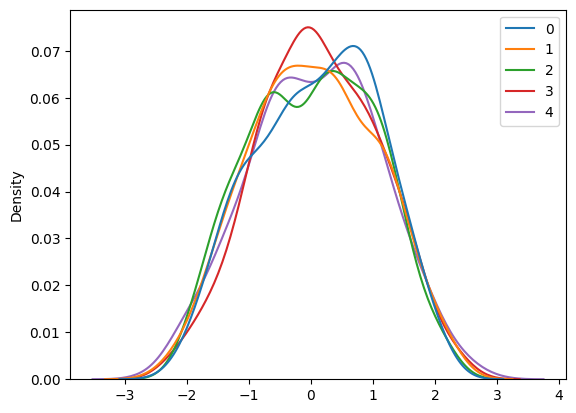

In [237]:
sns.kdeplot(X_val_transformed)
plt.show()

In [257]:
# # --- Step 1: Apply Log Transform to the Target (y) ---
# y_train_log = np.log1p(y_train)
# y_val_log = np.log1p(y_val)
# y_test_log = np.log1p(y_test)

# y_large_log = np.log1p(y_test_large)

# Initialize separate scalers for X and y
# x_scaler = StandardScaler()
pt = PowerTransformer(method='yeo-johnson')
pt_x = PowerTransformer(method='yeo-johnson', standardize=True)

# y_scaler = StandardScaler()

# --- Scaling for Features (X) ---

# Fit and transform on the training data X
# x_train_scaled = x_scaler.fit_transform(x_train)

# # Only transform the validation and test data X
# x_val_scaled = x_scaler.transform(x_val)
# x_test_scaled = x_scaler.transform(x_test)
# x_large_scaled = x_scaler.transform(X_test_large)
# y_train.reshape(-1, 1)
ytrain_reshaped = y_train.reshape(-1, 1)
yval_reshaped = y_val.reshape(-1, 1)
ytest_reshaped = y_test.reshape(-1, 1)
ytest_large_reshaped = y_test_large.reshape(-1,1)
ytrain_transformed = pt.fit_transform(ytrain_reshaped)
yval_transformed = pt.transform(yval_reshaped)
X_train_transformed = pt_x.fit_transform(x_train)
X_val_transformed = pt_x.transform(x_val)
X_test_transformed = pt_x.transform(x_test)
x_large_scaled = pt_x.transform(X_test_large)

# --- Scaling for the Target (y) ---

# Fit and transform on the training data y, remembering to reshape
# y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))

# # Only transform the validation and test data y, remembering to reshape
# y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
# y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

### Define the Model

In [400]:
def ModelApprox():        
    # model = Sequential()
    # model.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dense(1))
    # keras.layers.Dense(128, activation='relu', input_shape=(2,)),
    #     keras.layers.Dense(128, activation='relu'),
    #     keras.layers.Dense(64, activation='relu'),
    #     keras.layers.Dense(64, activation='relu'),
    model = keras.models.Sequential([
        keras.layers.Dense(1024, activation='relu', input_shape=(6,)),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        # keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2), 
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(4, activation='relu'),
        # keras.layers.Dropout(0.2), 
        # keras.layers.Dropout(0.2), 
        # keras.layers.Dense(8, activation='relu'),
        # keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(2, activation='relu'),
        keras.layers.Dense(1)
    ])
    return model

In [192]:
def ModelApproxConv1D(input_dim):        
    shape = (input_dim,1)

    model = keras.models.Sequential([
        Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=shape),   
        # Conv1D(filters=512, kernel_size=3, activation='relu'),
        LayerNormalization(),
        Flatten(),
        Dropout(0.2), 
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        # keras.layers.Dropout(0.2), 
        # keras.layers.Dense(256, activation='relu'),
        # keras.layers.Dense(256, activation='relu'),
        # keras.layers.Dropout(0.2), 
        # # keras.layers.Dense(128, activation='relu'),
        # # keras.layers.Dense(128, activation='relu'),
        # # keras.layers.Dropout(0.2), 
        # keras.layers.Dense(8, activation='relu'),
        # keras.layers.Dense(8, activation='relu'),
        Dense(1)
    ])
    return model

In [1]:
def ModelApproxConv1D_Simple(input_dim):
    shape = (input_dim, 1)
    model = keras.models.Sequential([
        # Cukup satu atau dua blok Conv1D
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=shape),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        Flatten(),
        # Cukup satu atau dua lapisan Dense
        Dense(32, activation='relu'),
        Dropout(0.3), # Anda bisa coba naikkan rate dropout
        Dense(1)
    ])
    return model

In [371]:
def ModelApproxConv1D_Regularized(input_dim):
    # Input shape untuk model adalah (panjang_sekuens, jumlah_fitur_per_langkah)
    shape = (input_dim, 1)
    
    # Nilai denda untuk regularizer L2
    l2_strength = 0.001

    model = keras.models.Sequential([
        # Menambahkan L2 regularizer ke lapisan Conv1D
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=shape, 
               kernel_regularizer=regularizers.l2(l2_strength)),
        
        Conv1D(filters=32, kernel_size=3, activation='relu',
               kernel_regularizer=regularizers.l2(l2_strength)),
        
        Dropout(0.3),
        Flatten(),

        # Menambahkan L2 regularizer ke lapisan Dense
        Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        
        Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)),
        
        Dropout(0.2),
        Dense(1)
    ])
    return model

In [210]:

model = ModelApproxConv1D(input_dim=5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 512)            2048      
                                                                 
 layer_normalization (LayerN  (None, 3, 512)           1024      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

### Setup Model

In [229]:
# Define the directory and the model name
ModelName = 'Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]'
directory = f'./{ModelName}/' # Use a relative path like './'
filepath = os.path.join(directory, 'best_model.keras') # Complete path with filename

In [240]:
# Setup the model
opt = keras.optimizers.Adam(learning_rate=learningRate, clipnorm=1.0)
# model.compile(loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

# --- Best Practice: Ensure the directory exists ---
os.makedirs(directory, exist_ok=True)
print(f"Models will be saved to: {filepath}")

# Create the ModelCheckpoint callback with the correct filepath
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=filepath,          # Use the full path with filename
    save_best_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min' # Explicitly set mode to 'min' for loss
)

plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr = 1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Added EarlyStopping


Models will be saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/best_model.keras


In [241]:
# 1. Tentukan path ke FOLDER tempat Anda ingin menyimpan scaler
scaler_dir = os.path.join(directory, 'scalers')

# 2. Buat folder tersebut (aman jika folder sudah ada)
os.makedirs(scaler_dir, exist_ok=True)

# 3. Simpan setiap objek scaler sebagai file terpisah DI DALAM folder tersebut
x_scaler_filepath = os.path.join(scaler_dir, 'x_scaler.joblib')
# y_scaler_filepath = os.path.join(scaler_dir, 'y_scaler.joblib')

joblib.dump(x_scaler, x_scaler_filepath)
# joblib.dump(y_scaler, y_scaler_filepath)

print(f"Objek x_scaler disimpan di: {x_scaler_filepath}")
# print(f"Objek y_scaler disimpan di: {y_scaler_filepath}")

Objek x_scaler disimpan di: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/scalers\x_scaler.joblib


In [242]:
x_train_scaled.shape

(4000, 5)

In [243]:
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], 6, 1)
# x_val_reshaped = x_val_scaled.reshape(x_val_scaled.shape[0], 6, 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], 6, 1)
x_train_reshaped = X_train_transformed.reshape(X_train_transformed.shape[0], 5, 1)
x_val_reshaped = X_val_transformed.reshape(X_val_transformed.shape[0], 5, 1)
x_test_reshaped = X_test_transformed.reshape(X_test_transformed.shape[0], 5, 1)



In [260]:
x_large_reshaped = x_large_scaled.reshape(x_large_scaled.shape[0], 5, 1)



In [244]:
# Hapus graf komputasi Keras yang ada di memori
K.clear_session()

# Jalankan garbage collector Python untuk membersihkan objek
gc.collect()

6784

In [245]:
x_train_reshaped.shape

(4000, 5, 1)

In [246]:
# compile the model
# opt = keras.optimizers.Adam(learning_rate=learningRate)

model.compile(optimizer=opt, loss='mse')


In [247]:

history = model.fit(X_train_transformed,
                    ytrain_transformed,
                    epochs=1000,
                    batch_size=8,
                    validation_data=(X_val_transformed, yval_transformed), # Add validation data for the callbacks to monitor
                    callbacks=[checkpoint,
                                plateau,
                                early_stopping], # Add checkpoint to the list
                    verbose=1)

Epoch 1/1000
500/500 [==============================] - ETA: 0s - loss: 0.0580
Epoch 1: val_loss improved from inf to 0.10784, saving model to ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]\best_model.keras
500/500 [==============================] - 3s 4ms/step - loss: 0.0580 - val_loss: 0.1078 - lr: 1.0000e-04
Epoch 2/1000
500/500 [==============================] - ETA: 0s - loss: 0.0632
Epoch 2: val_loss did not improve from 0.10784
500/500 [==============================] - 2s 3ms/step - loss: 0.0632 - val_loss: 0.1293 - lr: 1.0000e-04
Epoch 3/1000
499/500 [============================>.] - ETA: 0s - loss: 0.0601
Epoch 3: val_loss improved from 0.10784 to 0.08953, saving model to ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]\best_model.keras
500/500 [==============================] - 2s 3ms/step - loss: 0.0600 - val_loss: 0.0895 - lr: 1.0000e-04
Epoch 4/1000
498/500 [============================>.] - ETA: 0s - loss

### Evaluate the model

In [168]:
# make predictions using the trained model
y_pred = model.predict(x_test_scaled)

24/24 [==============================] - 0s 2ms/step


In [332]:
y_train_pred = model.predict(x_train_scaled)

110/110 [==============================] - 0s 2ms/step


In [333]:
y_pred_scaled = model.predict(x_test_scaled)

24/24 [==============================] - 0s 1ms/step


In [27]:
x_large_reshaped.shape

(100000, 6, 1)

In [220]:
y_train_pred_scaled = model.predict(X_train_transformed)


125/125 [==============================] - 0s 3ms/step


In [225]:
print(y_train)

[0.95865527 0.65185855 1.02634511 ... 0.15143891 0.05890939 0.86069059]


In [239]:

# Cek keberadaan NaN pada kedua array
print(f"Apakah ada NaN di y_train? {np.isnan(y_train).any()}")
print(f"Apakah ada NaN di y_train_pred_final? {np.isnan(y_train_pred_final).any()}")

# Jika ada, hitung jumlahnya untuk melihat seberapa parah masalahnya
if np.isnan(y_train_pred_final).any():
    print(f"Jumlah NaN di y_train_pred_final: {np.isnan(y_train_pred_final).sum()}")

Apakah ada NaN di y_train? False
Apakah ada NaN di y_train_pred_final? True
Jumlah NaN di y_train_pred_final: 1


In [261]:
# --- 1. Evaluate on Training Set ---
print("--- Training Set Metrics ---")
# Predict on the training data
# y_train_pred_scaled = model.predict(x_train_scaled)
y_train_pred_scaled = model.predict(X_train_transformed)

# Inverse transform the predictions
y_train_pred_final = pt.inverse_transform(y_train_pred_scaled)
# y_train_pred_final = np.expm1(y_train_pred_log)
# Calculate and print metrics
mse_train = mean_squared_error(y_train, y_train_pred_final)
mae_train = mean_absolute_error(y_train, y_train_pred_final)
r2_train = r2_score(y_train, y_train_pred_final)
print(f"MSE: {mse_train:.8f}")
print(f"MAE: {mae_train:.8f}")
print(f"R² Score: {r2_train:.4f}\n")


print("--- Large Testing Set Metrics ---")

y_large = model.predict(x_large_reshaped)

# # # Inverse transform the predictions
y_large_final = pt.inverse_transform(y_large)
# y_large_final= np.expm1(y_train_pred_log)
# Calculate and print metrics
mse_test_100k = mean_squared_error(y_test_large, y_large_final)
mae_test_100k = mean_absolute_error(y_test_large, y_large_final)
r2_test_100k = r2_score(y_test_large, y_large_final)
print(f"MSE: {mse_test_100k:.8f}")
print(f"MAE: {mae_test_100k:.8f}")
print(f"R² Score: {r2_test_100k:.4f}\n")


# --- 2. Evaluate on Validation Set ---
print("--- Validation Set Metrics ---")
# Predict on the validation data
# y_val_pred_scaled = model.predict(x_val_scaled)
y_val_pred_scaled = model.predict(X_val_transformed)
# # Inverse transform the predictions
y_val_pred_final = pt.inverse_transform(y_val_pred_scaled)
# y_val_pred_final = np.expm1(y_val_pred_log)
# Calculate and print metrics
mse_val = mean_squared_error(y_val, y_val_pred_final)
mae_val = mean_absolute_error(y_val, y_val_pred_final)
r2_val = r2_score(y_val, y_val_pred_final)
print(f"MSE: {mse_val:.8f}")
print(f"MAE: {mae_val:.8f}")
print(f"R² Score: {r2_val:.4f}\n")


# --- 3. Evaluate on Test Set ---
print("--- Test Set Metrics ---")
# Predict on the test data
# y_test_pred_scaled = model.predict(x_test_scaled)
y_test_pred_scaled = model.predict(X_test_transformed)
# Inverse transform the predictions
y_test_pred_final = pt.inverse_transform(y_test_pred_scaled)
# y_test_pred_final = np.expm1(y_test_pred_log)
# Calculate and print metrics
mse_test = mean_squared_error(y_test, y_test_pred_final)
mae_test = mean_absolute_error(y_test, y_test_pred_final)
r2_test = r2_score(y_test, y_test_pred_final)
print(f"MSE: {mse_test:.8f}")
print(f"MAE: {mae_test:.8f}")
print(f"R² Score: {r2_test:.4f}\n")

--- Training Set Metrics ---
125/125 [==============================] - 0s 3ms/step
MSE: 0.00056385
MAE: 0.01160847
R² Score: 0.9860

--- Large Testing Set Metrics ---
157/157 [==============================] - 0s 1ms/step
MSE: 0.00098664
MAE: 0.01266553
R² Score: 0.9750

--- Validation Set Metrics ---
16/16 [==============================] - 0s 1ms/step
MSE: 0.00450498
MAE: 0.01953122
R² Score: 0.8779

--- Test Set Metrics ---
16/16 [==============================] - 0s 1ms/step
MSE: 0.00085067
MAE: 0.01425634
R² Score: 0.9770



In [262]:
os.makedirs(directory, exist_ok=True)

# 2. Define the path for the full report file
report_filepath = os.path.join(directory, 'full_evaluation_report.txt')

# 3. Open the file in write mode and save all metrics
with open(report_filepath, 'w') as f:
    f.write(f"Full Evaluation Report for model: {ModelName}\n")
    f.write("========================================\n\n")
    
    # --- Write Training Set Metrics ---
    f.write("--- Training Set Metrics ---\n")
    f.write(f"MSE: {mse_train:.8f}\n")
    f.write(f"MAE: {mae_train:.8f}\n")
    f.write(f"R² Score: {r2_train:.4f}\n\n")
    
    # --- Write Validation Set Metrics ---
    f.write("--- Validation Set Metrics ---\n")
    f.write(f"MSE: {mse_val:.8f}\n")
    f.write(f"MAE: {mae_val:.8f}\n")
    f.write(f"R² Score: {r2_val:.4f}\n\n")
    
    # --- Write Test Set Metrics ---
    f.write("--- Test Set Metrics ---\n")
    f.write(f"MSE: {mse_test:.8f}\n")
    f.write(f"MAE: {mae_test:.8f}\n")
    f.write(f"R² Score: {r2_test:.4f}\n")

     # --- Write Test Set Metrics ---
    f.write("--- Test 100k Data Set Metrics ---\n")
    f.write(f"MSE: {mse_test_100k:.8f}\n")
    f.write(f"MAE: {mae_test_100k:.8f}\n")
    f.write(f"R² Score: {r2_test_100k:.4f}\n")


print(f"Full report successfully saved to: {report_filepath}")

Full report successfully saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/full_evaluation_report.txt


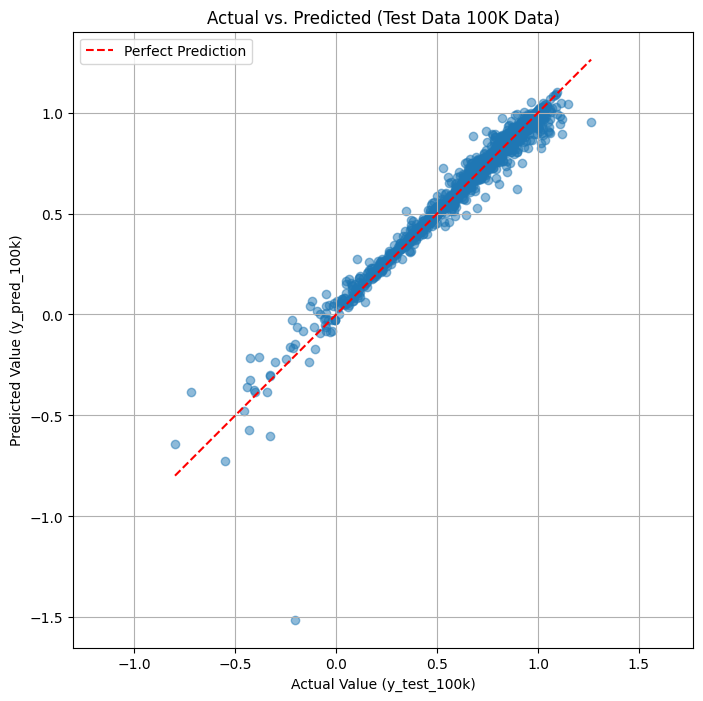

Plot successfully saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/actual_vs_predicted_plot_testing100k.png


In [265]:
# 1. Define the full path for the plot image file
#    It's good practice to save it in the same directory as your other results.
plot_filepath = os.path.join(directory, 'actual_vs_predicted_plot_testing100k.png')

# 2. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_large, y_large_final, alpha=0.5)

# Create the perfect prediction line
perfect_line = np.linspace(min(y_test_large), max(y_test_large), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.title('Actual vs. Predicted (Test Data 100K Data)')
plt.xlabel('Actual Value (y_test_100k)')
plt.ylabel('Predicted Value (y_pred_100k)')
plt.grid(True)
plt.legend()
plt.axis('equal')

# 3. Save the figure to the specified path BEFORE showing it
plt.savefig(plot_filepath)

# 4. Display the plot
plt.show()

print(f"Plot successfully saved to: {plot_filepath}")

Plot Testing Data

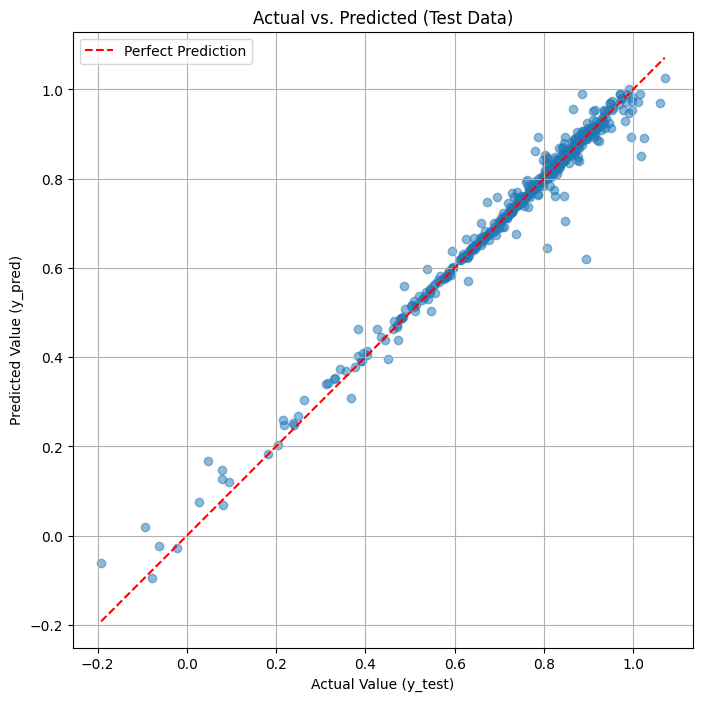

Plot successfully saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/actual_vs_predicted_plot.png


In [250]:
# 1. Define the full path for the plot image file
#    It's good practice to save it in the same directory as your other results.
plot_filepath = os.path.join(directory, 'actual_vs_predicted_plot.png')

# 2. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_final, alpha=0.5)

# Create the perfect prediction line
perfect_line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.title('Actual vs. Predicted (Test Data)')
plt.xlabel('Actual Value (y_test)')
plt.ylabel('Predicted Value (y_pred)')
plt.grid(True)
plt.legend()
plt.axis('equal')

# 3. Save the figure to the specified path BEFORE showing it
plt.savefig(plot_filepath)

# 4. Display the plot
plt.show()

print(f"Plot successfully saved to: {plot_filepath}")

Plot Training Data

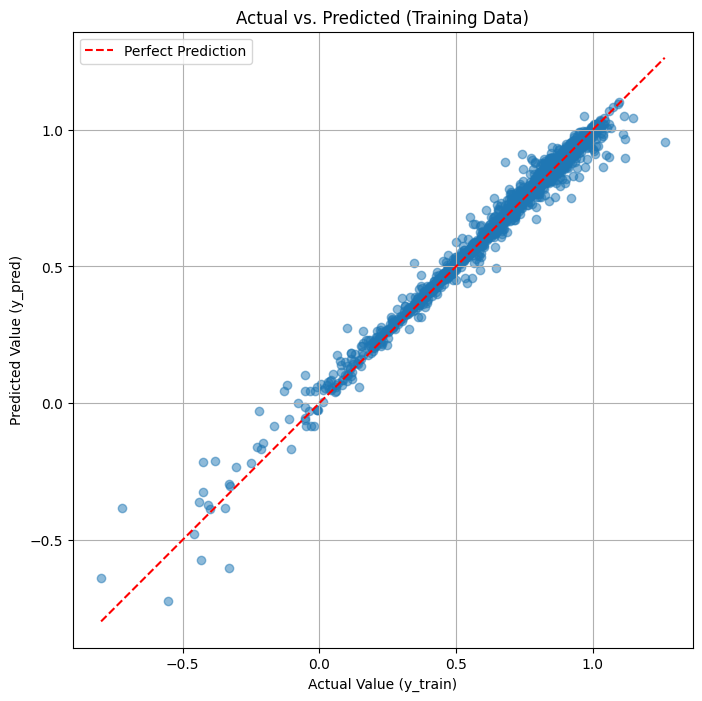

Training plot successfully saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/train_actual_vs_predicted.png


In [251]:
# 1. Define the full path for the plot image file
plot_filepath_train = os.path.join(directory, 'train_actual_vs_predicted.png')

# 2. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred_final, alpha=0.5)

# Create the perfect prediction line
perfect_line = np.linspace(min(y_train), max(y_train), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.title('Actual vs. Predicted (Training Data)')
plt.xlabel('Actual Value (y_train)')
plt.ylabel('Predicted Value (y_pred)')
plt.grid(True)
plt.legend()
plt.axis('equal')

# 3. Save the figure before showing it
plt.savefig(plot_filepath_train)

# 4. Display the plot
plt.show()

print(f"Training plot successfully saved to: {plot_filepath_train}")

Plot Validation Data

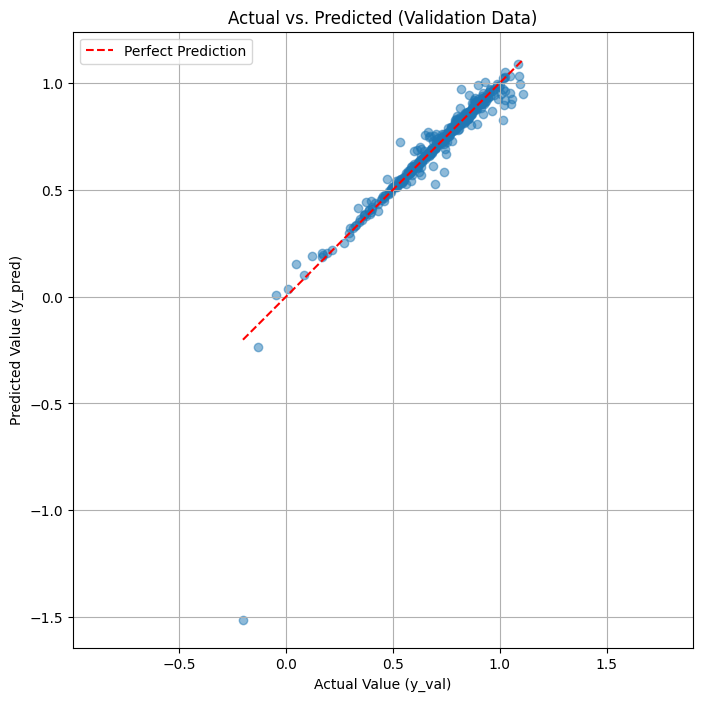

Validation plot successfully saved to: ./Oneloop-5K-Conv1DDense-Preprocessing[Yeo]X and Y-2layer dense+less wider[conv]/validation_actual_vs_predicted.png


In [252]:
# 1. Define the full path for the plot image file 
plot_filepath_val = os.path.join(directory, 'validation_actual_vs_predicted.png')

# 2. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_val_pred_final, alpha=0.5)

# Create the perfect prediction line
perfect_line = np.linspace(min(y_val), max(y_val), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.title('Actual vs. Predicted (Validation Data)')
plt.xlabel('Actual Value (y_val)')
plt.ylabel('Predicted Value (y_pred)')
plt.grid(True)
plt.legend()
plt.axis('equal')

# 3. Save the figure before showing it
plt.savefig(plot_filepath_val)

# 4. Display the plot
plt.show()

print(f"Validation plot successfully saved to: {plot_filepath_val}")

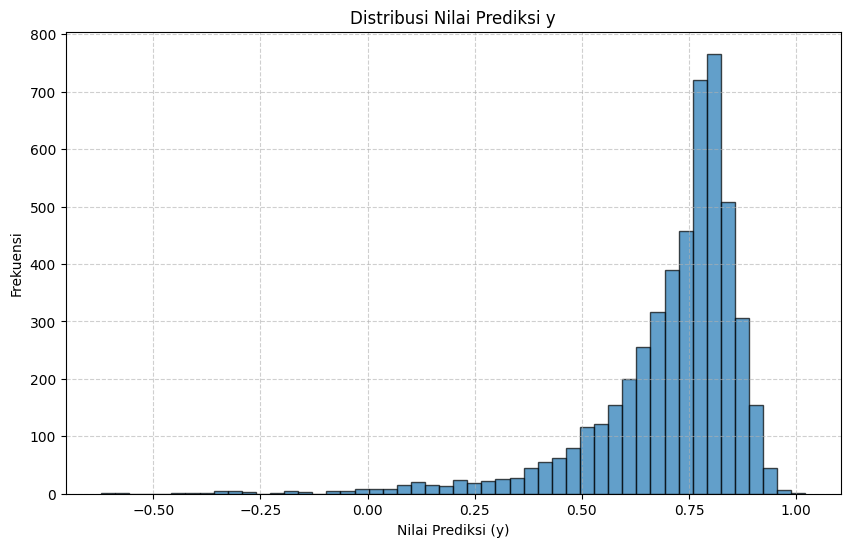

In [50]:
# Pastikan y_large adalah array 1D untuk plotting
y_values = y_large.flatten()

# Membuat histogram
plt.figure(figsize=(10, 6))
plt.hist(y_values, bins=50, edgecolor='black', alpha=0.7)

# Menambahkan judul dan label
plt.title('Distribusi Nilai Prediksi y')
plt.xlabel('Nilai Prediksi (y)')
plt.ylabel('Frekuensi')
plt.grid(True, linestyle='--', alpha=0.6)

# Menampilkan plot
plt.show()

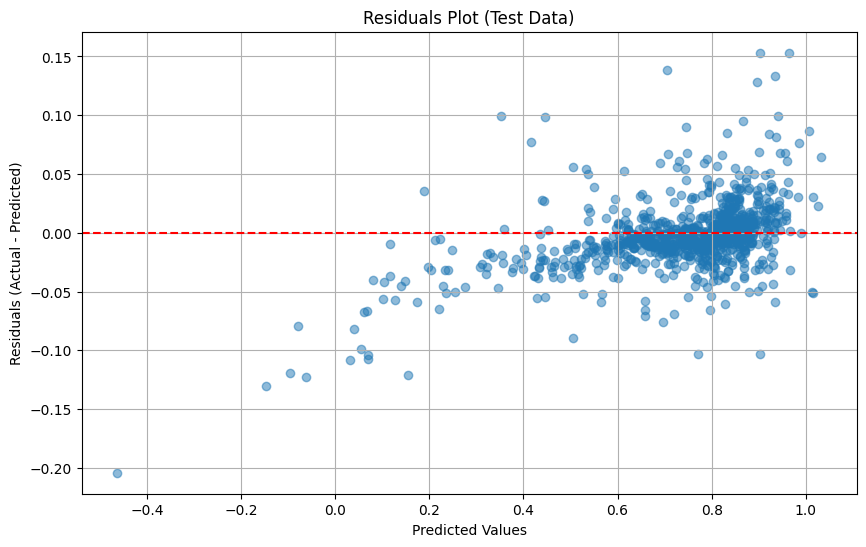

In [24]:
# 1. Calculate the residuals (the errors)
#    Ensure y_test_pred_final is a 1D array to match y_test
residuals = y_test - y_test_pred_scaled.flatten()

# 2. Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_scaled, residuals, alpha=0.5)

# 3. Add a horizontal line at y=0 for reference (zero error)
plt.axhline(y=0, color='red', linestyle='--')

# 4. Add labels and title
plt.title('Residuals Plot (Test Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)

# 5. Display the plot
plt.show()

In [42]:
if X is not None and 'y_large' in locals():
    
    if X.shape[0] != y_large.shape[0]:
        print("Error: Jumlah baris antara X dan y_large tidak cocok!")
    else:
        data_gabungan = np.concatenate((X, y_large), axis=1)
        
        print(f"\nBerhasil menggabungkan data. Shape baru: {data_gabungan.shape}")
        print("Contoh 5 baris pertama dari data gabungan:")
        print(data_gabungan[:5])

        # Menyimpan array gabungan ke file .txt baru
        file_baru = 'uux_ttxa_events_100+ML_Predict.txt'
        np.savetxt(file_baru, data_gabungan, delimiter=',', fmt='%f')
        
        print(f"\nData gabungan telah berhasil disimpan ke file '{file_baru}' ✅")


Berhasil menggabungkan data. Shape baru: (100000, 9)
Contoh 5 baris pertama dari data gabungan:
[[4.37101993e+05 1.60306146e+05 3.51056043e+05 9.04307775e+03
  3.66847863e+04 2.99290000e+04 1.13296527e-04 4.79950127e-01
  5.06669998e-01]
 [1.89839060e+05 4.48484286e+04 7.64398704e+04 6.28418906e+04
  3.14514494e+04 2.99290000e+04 1.45527019e-05 7.75308958e-01
  7.70369053e-01]
 [1.76659128e+05 3.96910229e+04 4.60822100e+04 6.89453308e+04
  3.00903945e+04 2.99290000e+04 9.95894683e-06 8.24478719e-01
  8.09353709e-01]
 [3.41031722e+05 8.85730959e+04 2.50398300e+05 5.66515498e+04
  3.68757225e+04 2.99290000e+04 5.98518681e-05 5.51041769e-01
  5.70268273e-01]
 [1.99224163e+05 1.32788295e+05 8.58447387e+04 2.95493784e+04
  8.01925494e+04 2.99290000e+04 5.04448080e-05 9.30615781e-01
  9.04497623e-01]]

Data gabungan telah berhasil disimpan ke file 'uux_ttxa_events_100+ML_Predict.txt' ✅


In [266]:
if X is not None and 'y_large' in locals():
    
    if X.shape[0] != y_large.shape[0]:
        print("Error: Jumlah baris tidak cocok!")
    else:
        # Menggabungkan data (tidak berubah)
        data_gabungan = np.concatenate((X, y_large), axis=1)
        print(f"\nBerhasil menggabungkan data. Shape baru: {data_gabungan.shape}")
        
        # --- Metode Penyimpanan Baru ---
        
        # 1. Ubah array NumPy kembali ke format list of lists Python
        data_sebagai_list = data_gabungan.tolist()
        
        # 2. Ubah keseluruhan list menjadi satu string tunggal
        data_sebagai_string = str(data_sebagai_list)
        
        # 3. Tulis string tersebut ke dalam file .txt
        file_baru = 'uux_ttxa_events_100+ML_Predict_formatted(new).txt'
        try:
            with open(file_baru, 'w') as f:
                f.write(data_sebagai_string)
            print(f"\nData gabungan telah berhasil disimpan ke '{file_baru}' dengan format yang benar ✅")
        except Exception as e:
            print(f"Gagal menyimpan file: {e}")


Berhasil menggabungkan data. Shape baru: (5000, 9)

Data gabungan telah berhasil disimpan ke 'uux_ttxa_events_100+ML_Predict_formatted(new).txt' dengan format yang benar ✅
